## **MFCC and SVM feature extraction pipleine**

# Understanding MFCCs and Their Derivatives in Audio ML

## What are MFCCs?

When you look at an audio waveform, you see **amplitude vs time**, but that doesn't capture **how humans perceive sound**.  

**MFCCs (Mel-Frequency Cepstral Coefficients)** help with that:

- Break audio into short frames (~20–40 ms each).  
- Compute the **spectrum** for each frame.  
- Map frequencies to the **Mel scale** (like human hearing).  
- Take the **cepstral transform** to capture the **shape of the spectrum**.  

Result: each frame produces a **vector of coefficients** (e.g., 13 values) that describe the spectral shape — essentially a **fingerprint of the sound**.

---

## Why MFCCs alone are not enough

MFCCs describe the **static spectral shape** at each moment.  

- Audio is dynamic — speech, music, and environmental sounds **change over time**.  
- Two sounds can have similar MFCCs at a single frame but differ in **how they evolve**.

---

## Delta MFCCs (First Derivative)

The **delta MFCC** is the **rate of change** of MFCCs over time:

\[
\Delta MFCC(t) = MFCC(t+1) - MFCC(t-1)
\]

- Captures **temporal dynamics** (how the sound changes).  
- Helps ML models distinguish sounds with similar static spectra but different timing.  
- Example: differentiating “ba” vs “pa” in speech.

---

## Delta-Delta MFCCs (Second Derivative)

The **delta-delta MFCC** is the **acceleration** of MFCC changes:

\[
\Delta^2 MFCC(t) = \Delta MFCC(t+1) - \Delta MFCC(t-1)
\]

- Captures **higher-order dynamics**, such as rapid transitions, intonation, or vibrato.  
- Complements static MFCCs and delta features for a **richer representation**.

---

## How this helps in Machine Learning

- **MFCCs** → static fingerprint of each frame.  
- **Delta MFCCs** → temporal evolution of the fingerprint.  
- **Delta-Delta MFCCs** → acceleration of changes.  

Stacking all three features gives your ML model a **full picture of both spectral content and dynamics**, which is essential for:

- Speech recognition  
- Music genre classification  
- Environmental sound detection

---

## Visualization Concept

| Feature | What it shows |
|---------|---------------|
| MFCC    | Snapshot of spectral shape (static) |
| Delta   | Slope or change over time |
| Delta-Delta | Acceleration or rapid transitions |

Together, they form a **rich, dynamic feature set** for audio ML tasks.


In [1]:
!pip install librosa

In [2]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from pathlib import Path

In [4]:
# Set root (WSL Linux path)
root = Path("/home/rime/music-recom")

audio_path = root / "data" / "audio" / "000010.mp3"
print(audio_path.exists())  # True if file exists

ipd.Audio(filename=str(audio_path))

True


In [5]:
# Signal and sampling rate
signal, sr = librosa.load(audio_path)

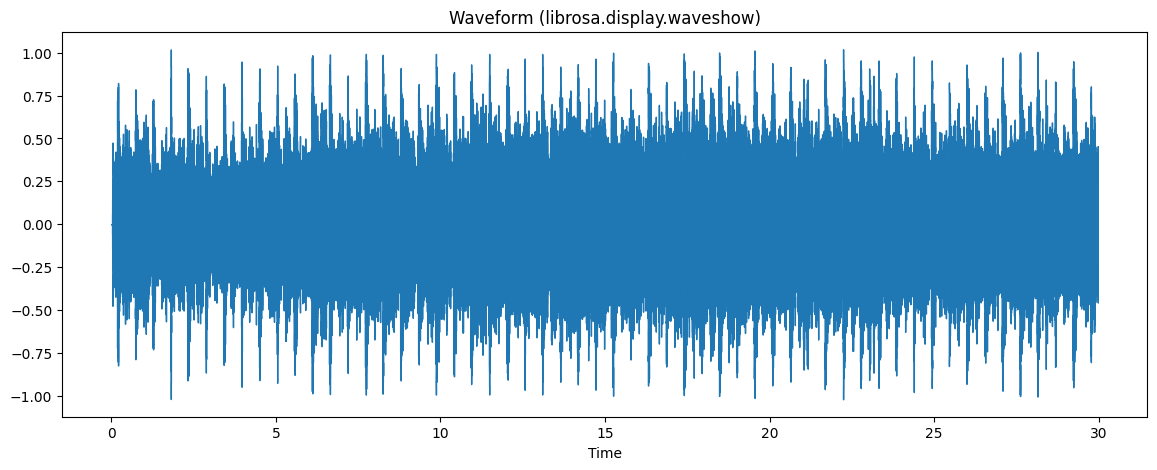

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform (librosa.display.waveshow)")
plt.show()

In [7]:
signal.shape

(660984,)

Extracting mfccs

In [8]:
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

In [9]:
mfccs.shape

(13, 1291)

Visualising mfccs

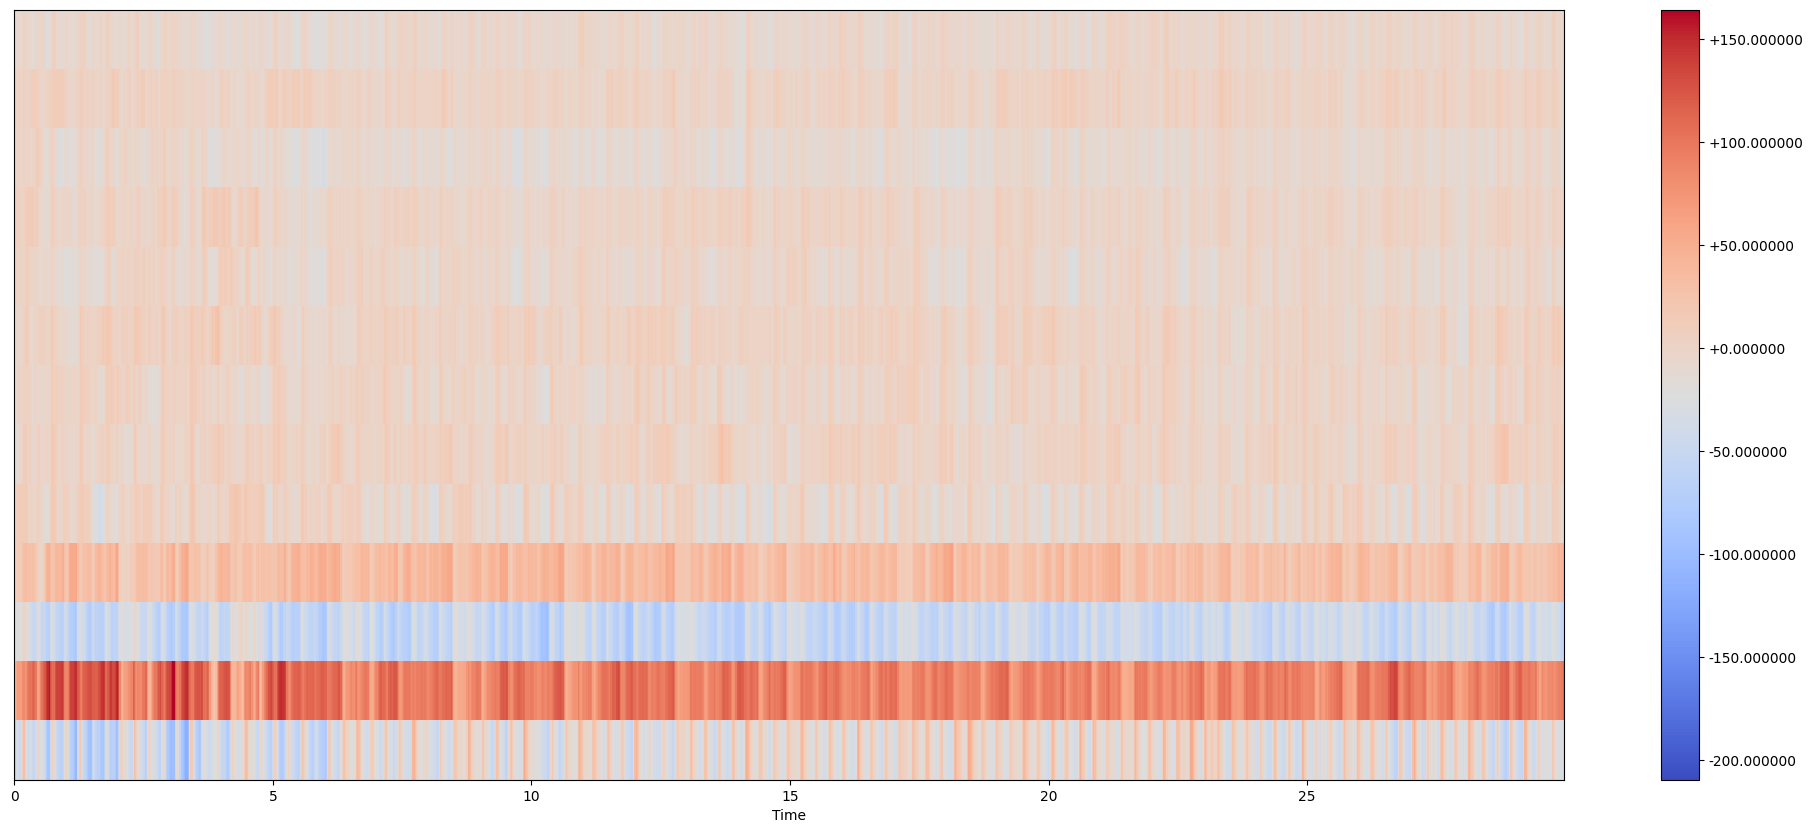

In [10]:
plt.figure(figsize=(25,10))

librosa.display.specshow(mfccs,
                       x_axis = "time",
                       sr=sr)

# Mapping colors to numerical values
plt.colorbar(format= '%+2f')

plt.show()

1st and 2nd derivative of mfccs (how mfccs change over time)

In [11]:
# Calculate delta and delta2 MFCCS
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [12]:
delta_mfccs.shape
# Same shape as the mfccs

(13, 1291)

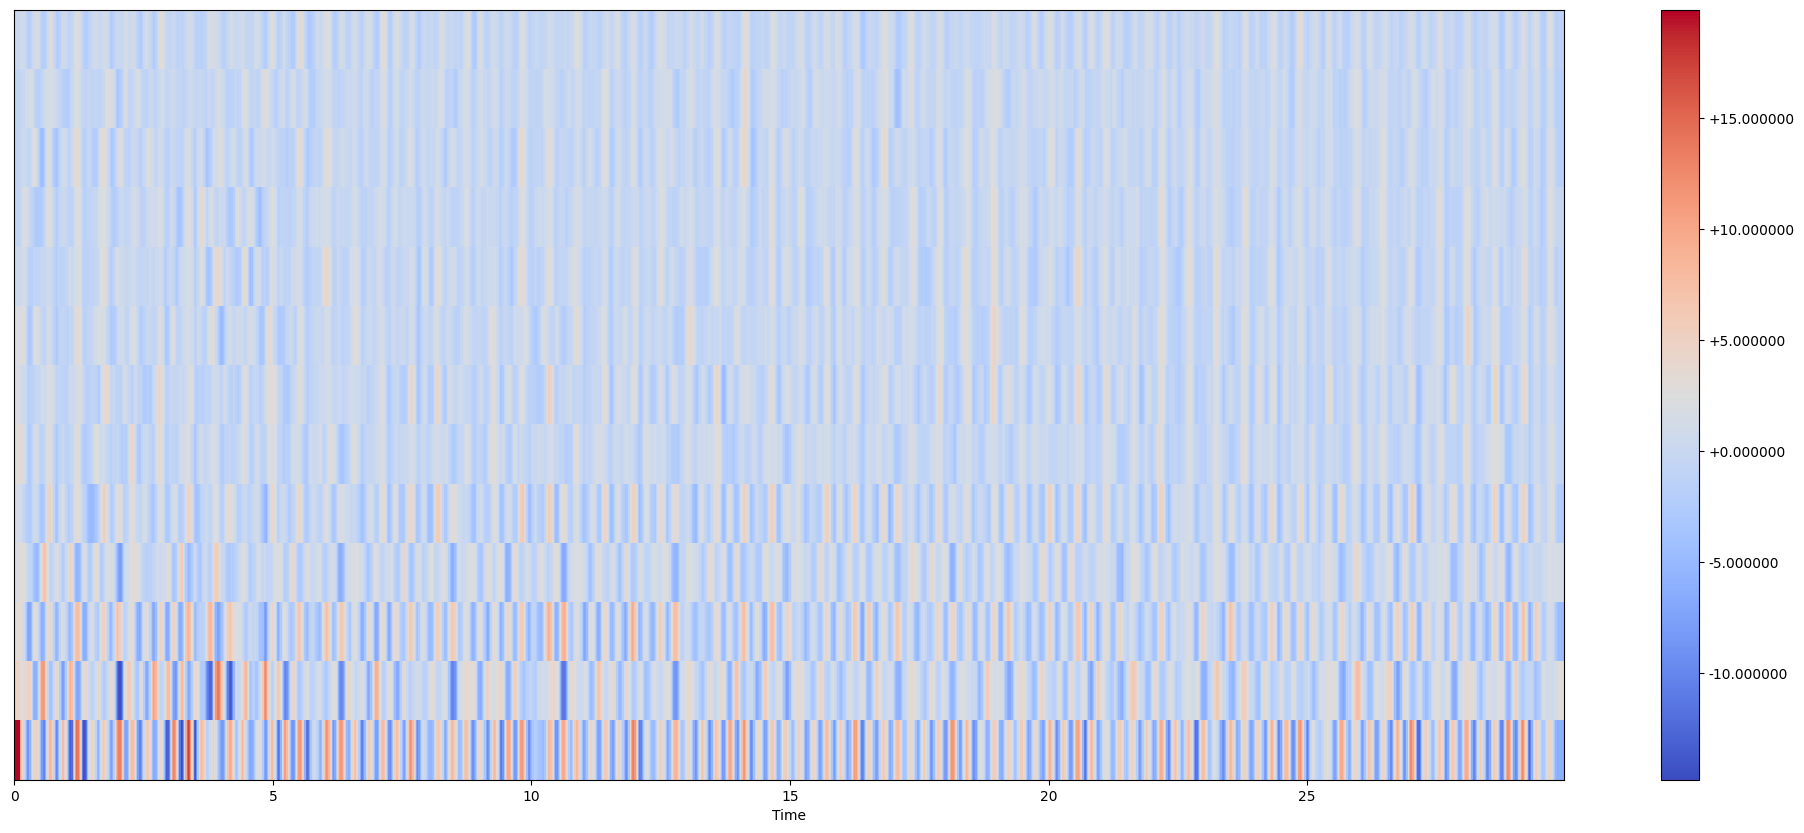

In [13]:
plt.figure(figsize=(25,10))

librosa.display.specshow(delta_mfccs,
                       x_axis = "time",
                       sr=sr)

# Mapping colors to numerical values
plt.colorbar(format= '%+2f')

plt.show()

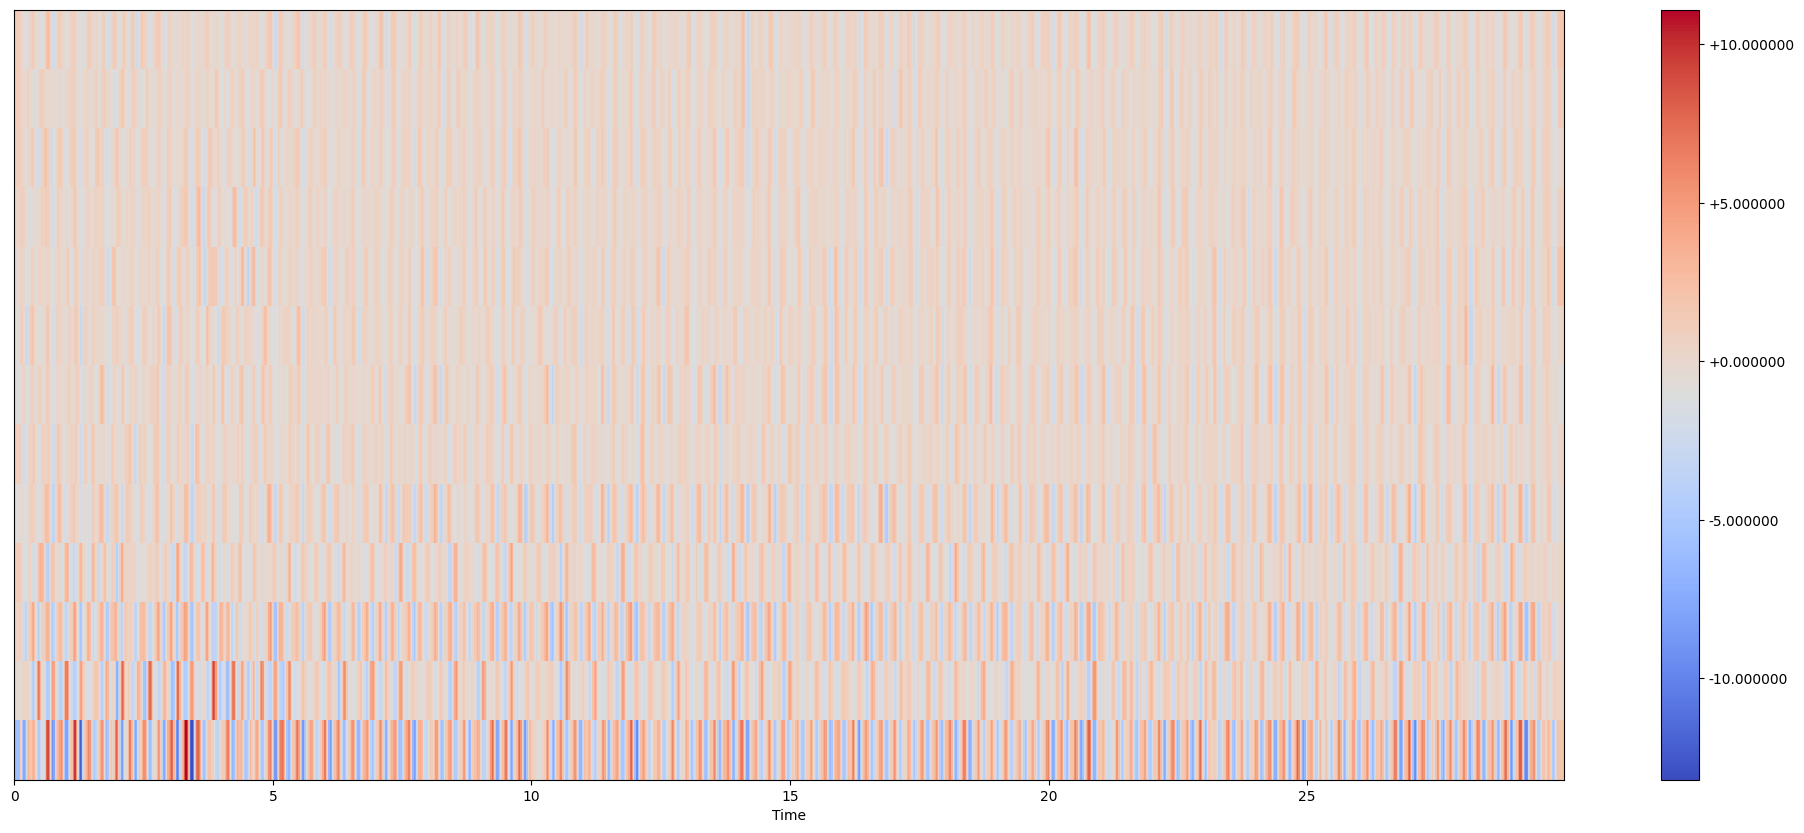

In [14]:
plt.figure(figsize=(25,10))

librosa.display.specshow(delta2_mfccs,
                       x_axis = "time",
                       sr=sr)

# Mapping colors to numerical values
plt.colorbar(format= '%+2f')

plt.show()

In [15]:
comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

In [16]:
comprehensive_mfccs.shape

(39, 1291)

- 39 rows → features per frame (13 MFCC + 13 delta + 13 delta-delta)

- n_frames columns → time slices of the song (depends on song length and frame size)

So for one song, **we have a matrix**, not a single vector.

### Justification for Choosing Aggregation Over Flattening or PCA

When preparing audio features like MFCCs for SVM models, there are several possible approaches: 
- flattening along the time axis, applying PCA on flattened features
- aggregating features across frames. 

Flattening preserves all frame-level details, but it leads to **extremely high-dimensional vectors** (e.g., thousands of features per song), which can cause **overfitting** and make SVM training slow and unstable. PCA can reduce the dimensionality of flattened vectors, but it still requires that all songs have the **exact same number of frames**, and the resulting components are **harder to interpret**. Moreover, PCA may discard subtle but important information if too many components are removed.  

Aggregation, by contrast, computes **statistics such as mean and standard deviation across frames** for each coefficient (MFCC, delta, delta-delta), producing a **compact, fixed-length feature vector** for each song. This approach is **robust, interpretable, and SVM-friendly**, while still capturing both the average spectral content and its temporal dynamics. Aggregation avoids the high-dimensionality issues of flattening and the complexity of PCA, making it the most **efficient and practical choice** for song-level feature prediction tasks like danceability, energy, or valence.


### **Trial on all the songs**

In [17]:
import numpy as np
import pandas as pd
import librosa
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Extract features for all songs
def extract_mfcc_features(audio_path, n_mfcc=13, sr=220502):
    'Extract mfccs, delta mfcc and delta2 mfcc'

    try:
        # Load song
        signal, sr = librosa.load(audio_path,sr=sr)

        # Extract mfccs
        mfccs = librosa.feature.mfcc(y=signal,
                                 sr=sr,
                                 n_mfcc=n_mfcc)
    
        # Extract delta and delta2
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        # Aggregation : computing mean and std
        features = {}

        # MFCCS statistics
        features['mfcc_mean']=np.mean(mfccs, axis=1)
        features['mfcc_std']=np.std(mfccs, axis=1)

        # Deltas
        features['delta_mean']=np.mean(delta_mfccs, axis=1)
        features['delta2_mean']=np.mean(delta2_mfccs, axis=1)

        features['delta_std']=np.std(delta_mfccs, axis=1)
        features['delta2_std']=np.std(delta2_mfccs, axis=1)

        # Flattening all features into a single vector
        feature_vector = np.concatenate([
            features['mfcc_mean'],
            features['mfcc_std'],
            features['delta_mean'],
            features['delta_std'],
            features['delta2_mean'],
            features['delta2_std']
        ])

        return feature_vector, True

    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")

In [19]:
from tqdm import tqdm

def extract_features_for_dataset(df, n_mfcc=13, sr=22050):

    successful_ids = []
    feature_vectors = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting MFCC features"):
        track_id = row['track_id']
        audio_path = row['audio_path']
        
        # features extraction
        features, success = extract_mfcc_features(audio_path, n_mfcc=n_mfcc, sr=sr)
        
        if success:
            successful_ids.append(track_id)
            feature_vectors.append(features)
    
    # Name of columns
    feature_names = []
    for stat in ['mfcc_mean', 'mfcc_std', 'delta_mean', 'delta_std', 'delta2_mean', 'delta2_std']:
        for i in range(n_mfcc):
            feature_names.append(f"{stat}_{i}")
    
   
    features_df = pd.DataFrame(feature_vectors, columns=feature_names)
    features_df.insert(0, 'track_id', successful_ids)
    
    print(f"\n✓ Successfully extracted features for {len(features_df)}/{len(df)} songs")
    print(f"✓ Feature vector dimension: {len(feature_names)} (13 MFCCs × 6 statistics)")
    
    return features_df

In [20]:
# Charger le fichier existant
id_music_list_df = pd.read_csv('/home/rime/music-recom/data/processed/audio_files_list.csv')

print(f"Loaded {len(id_music_list_df)} audio files")
print(id_music_list_df.head())

# Extraire les features MFCC directement
mfcc_features_df = extract_features_for_dataset(id_music_list_df, n_mfcc=13, sr=22050)

# Sauvegarder
output_path = Path("/home/rime/music-recom/data/processed/mfcc_features.csv")
mfcc_features_df.to_csv(output_path, index=False)
print(f"\n✓ Saved features to {output_path}")

Loaded 1590 audio files
   track_id                                    audio_path
0    109497  \home\rime\music-recom\data\audio\109497.mp3
1     53666  \home\rime\music-recom\data\audio\053666.mp3
2     55400  \home\rime\music-recom\data\audio\055400.mp3
3     10589  \home\rime\music-recom\data\audio\010589.mp3
4     55923  \home\rime\music-recom\data\audio\055923.mp3


Extracting MFCC features: 100%|██████████| 1590/1590 [59:23<00:00,  2.24s/it]  



✓ Successfully extracted features for 1590/1590 songs
✓ Feature vector dimension: 78 (13 MFCCs × 6 statistics)

✓ Saved features to \home\rime\music-recom\data\processed\mfcc_features.csv


In [22]:
pd.set_option('display.max_columns', None)
mfcc_features_df.head()

,track_id,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_std_0,mfcc_std_1,mfcc_std_2,mfcc_std_3,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,delta_mean_0,delta_mean_1,delta_mean_2,delta_mean_3,delta_mean_4,delta_mean_5,delta_mean_6,delta_mean_7,delta_mean_8,delta_mean_9,delta_mean_10,delta_mean_11,delta_mean_12,delta_std_0,delta_std_1,delta_std_2,delta_std_3,delta_std_4,delta_std_5,delta_std_6,delta_std_7,delta_std_8,delta_std_9,delta_std_10,delta_std_11,delta_std_12,delta2_mean_0,delta2_mean_1,delta2_mean_2,delta2_mean_3,delta2_mean_4,delta2_mean_5,delta2_mean_6,delta2_mean_7,delta2_mean_8,delta2_mean_9,delta2_mean_10,delta2_mean_11,delta2_mean_12,delta2_std_0,delta2_std_1,delta2_std_2,delta2_std_3,delta2_std_4,delta2_std_5,delta2_std_6,delta2_std_7,delta2_std_8,delta2_std_9,delta2_std_10,delta2_std_11,delta2_std_12
0,109497,-14.466280,99.482414,-13.127948,43.313545,9.995256,5.399690,-5.793285,13.883069,-1.838130,2.187864,-2.674747,3.841628,-9.301169,26.336906,13.115074,12.082673,10.713166,7.633687,5.559512,5.984025,5.907621,5.963255,5.159916,5.725162,4.790164,5.414805,0.220803,0.009053,-0.002882,-0.003425,0.000750,0.004600,-0.003279,0.011742,0.006375,0.001650,0.000165,-0.000724,0.005746,4.416481,2.527710,1.879202,1.614143,1.372204,0.916860,1.072610,1.153425,1.141011,0.906527,1.142041,0.910949,1.012290,-0.135776,-0.035974,0.004075,-0.013851,-0.004475,-0.001072,-0.002500,-0.009171,-0.006136,-0.009151,-0.006148,-0.006779,-0.001375,2.662576,1.463119,1.183564,1.022441,0.859411,0.726816,0.796010,0.860587,0.880833,0.730460,0.814753,0.704768,0.741921
1,53666,-52.185890,99.239311,-19.818560,34.841202,-4.830251,7.452331,0.821418,-0.551589,0.541429,8.759988,-2.642872,6.468830,-2.554433,17.970594,16.446632,10.712290,8.822542,7.811877,5.619895,6.609158,6.775237,6.076496,6.250626,5.909140,5.741867,5.448841,0.012402,-0.007382,-0.005155,0.002076,-0.001866,-0.001652,-0.000474,-0.000553,-0.000199,0.011042,0.004957,-0.008891,-0.007915,3.199941,2.723585,2.005160,1.703189,1.259007,1.013505,1.200884,1.042044,1.084845,1.036201,1.091861,0.978752,1.000591,-0.011197,-0.015572,-0.007065,-0.002806,-0.001591,-0.006339,-0.008179,-0.007428,-0.002442,-0.002701,-0.006067,-0.005588,-0.005737,2.597663,1.668799,1.340824,1.059314,0.872083,0.693278,0.744236,0.724987,0.736523,0.742568,0.732206,0.654933,0.686628
2,55400,-37.400524,124.763824,-36.813068,21.995646,2.225886,21.032818,3.546124,10.978546,-5.663468,1.670306,-1.866043,4.414843,0.263866,25.074936,15.589418,11.059312,9.996412,8.603876,6.485661,7.064106,4.818400,4.594680,4.897986,4.508664,5.303911,5.510609,0.058065,-0.010560,0.011036,0.009491,-0.004898,0.002371,0.013210,0.016682,0.005274,0.004574,0.003347,0.005777,0.008513,4.374987,2.896858,1.517322,1.221072,1.538684,0.871887,1.157159,0.796285,0.784595,0.881469,0.744571,0.868556,0.739550,-0.057128,0.014514,-0.004043,0.006608,0.012310,-0.003013,0.000503,-0.001101,0.002705,-0.000753,-0.001030,0.000794,-0.001403,3.734957,1.728411,1.449256,1.055884,0.866639,0.662977,0.788613,0.562866,0.613871,0.658512,0.639172,0.613510,0.579289
3,10589,-380.002869,181.902252,-65.369286,10.870298,16.465267,-47.996254,-3.810153,-8.473989,-42.449268,-8.006559,-6.592747,-21.923281,-0.598965,65.707253,25.217339,45.143143,18.352695,13.137667,17.607540,8.177697,8.135131,13.139120,8.508199,9.304217,8.381541,8.219736,0.189026,0.083782,-0.052729,-0.005151,-0.000277,-0.026846,-0.010993,-0.013700,-0.027458,0.001743,0.007929,-0.008412,-0.008311,7.055398,3.073463,4.952223,2.348252,1.871211,1.966379,1.128496,1.124765,1.474231,1.269974,1.269533,1.053715,1.284437,-0.054324,-0.050451,0.013551,-0.010189,-0.012286,0.013427,-0.004870,-0.000656,0.008195,-0.000025,0.005310,0.010322,-0.001069,3.407578,1.517492,2.385228,1.016233,0.909341,0.999600,0.677607,0.646453,0.789100,0.651975,0.664161,0.649972,0.697728
4,55923,-18.598597,71.3

In [23]:
mfcc_features_df.shape

(1590, 79)